# Base qx

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sksurv.util import Surv
from sklearn.model_selection import train_test_split, GridSearchCV
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sklearn.metrics import log_loss
from scipy.special import logit
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'sksurv',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
sksurv version: 0.23.1
scipy version: 1.13.1


In [2]:
us_males = pd.read_csv("data/US_males.txt", sep='\s+', header=1)
us_females = pd.read_csv("data/US_females.txt", sep='\s+', header=1)

us_males = us_males.drop(us_males[us_males["Age"] == "110+"].index)
us_males = us_males.astype({"Age": "int64"})
us_females = us_females.drop(us_females[us_females["Age"] == "110+"].index)
us_females = us_females.astype({"Age": "int64"})

qx_males = us_males.qx[us_males["Year"] == 2019].values
qx_females = us_females.qx[us_females["Year"] == 2019].values

qx10_males = 1 - np.prod(1-np.lib.stride_tricks.sliding_window_view(qx_males, 10), axis = 1)
qx10_females = 1 - np.prod(1-np.lib.stride_tricks.sliding_window_view(qx_females, 10), axis = 1)

In [3]:
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy()
E = dfp_nn["event"].to_numpy()

y = Surv.from_arrays(event=E.astype(bool), time=T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
ages = X_test["AGE"].astype(int).values
sex = X_test["MALE"].astype(bool).values
q10 = np.where(sex, qx10_males[ages], qx10_females[ages])

# C-index
c_index = concordance_index_censored(
    y_test["event"], y_test["time"], q10
)[0]
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1, 10)
# Convert 10-year mortality qx to constant hazard lambda
lambdas = -np.log(1 - q10) / 10
surv_preds = np.exp(-np.outer(lambdas, time_grid))  # S(t) = exp(-lambda * t)
ibs = integrated_brier_score(y_test, y_test, surv_preds, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
in_interval = ((y_test["event"] == True) & (y_test["time"] >= 2) & (y_test["time"] < 3)).astype(int)
p_interval = surv_preds[:, 2] - surv_preds[:, 3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8402
Integrated Brier Score: 0.0439
Log loss for interval [2, 3): 0.0519


In [5]:
D2 = pd.read_csv("data/D2.csv")
X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = np.floor(D2["T"].to_numpy())
E_D2 = D2["event"].to_numpy()
mu_D2 = D2["mu"].to_numpy()

y_D2 = Surv.from_arrays(event=E_D2.astype(bool), time=T_D2)
X_D2_train, X_D2_test, y_D2_train, y_D2_test, _, mu_D2_test = train_test_split(X_D2, y_D2, mu_D2, test_size=0.2, random_state=0)

In [6]:
ages = X_D2_test["AGE"].astype(int).values
sex = X_D2_test["GENDER"].astype(bool).values
q10 = np.where(sex, qx10_females[ages], qx10_males[ages])

# C-index
c_index = concordance_index_censored(
    y_D2_test["event"], y_D2_test["time"], q10
)[0]
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1,10)
# Convert 10-year mortality qx to constant hazard lambda (this could be refined by taking into account increasing mortality by age)
lambdas = -np.log(1 - q10) / 10
surv_preds = np.exp(-np.outer(lambdas, time_grid))  # S(t) = exp(-lambda * t)
ibs = integrated_brier_score(y_D2_test, y_D2_test, surv_preds, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
logloss = log_loss(y_D2_test["event"], q10)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.8651
Integrated Brier Score: 0.0493
Log loss for interval [0, 10): 0.2326


In [7]:
events = y_D2_test["event"].astype(int)
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(q10)))
dev = -2*np.sum(events*logit(q10) + np.log(1-q10))
kld = -np.sum(np.log(q10[events==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    1.5217
Logistic deviance:           128056
Kullback-Leibler divergence: 38846


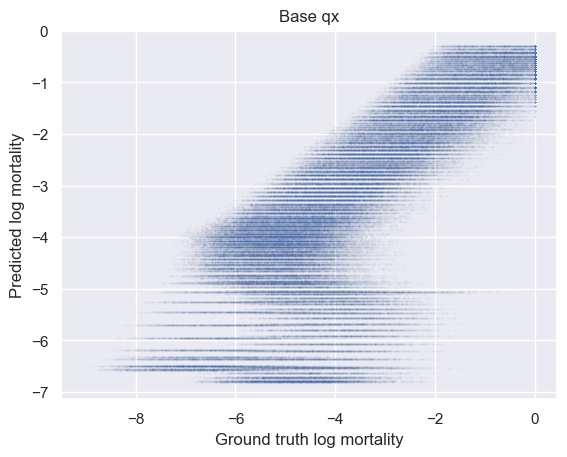

In [8]:
plt.plot(np.log(mu_D2_test), np.log(q10), '.', alpha=0.1, markersize=0.25)
plt.title("Base qx")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()